In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import zipfile

In [3]:
data_zip =('/content/drive/MyDrive/Colab Notebooks/dados.zip')
with zipfile.ZipFile(data_zip, 'r') as zip_ref:
    zip_ref.extractall("/content/data/")

In [4]:
from pathlib import Path
from typing import Dict, Optional
import pandas as pd

In [5]:
solar_wind = pd.read_csv('/content/data/solar_wind.csv')
labels = pd.read_csv('/content/data/labels.csv')
sunspots = pd.read_csv('/content/data/sunspots.csv')

In [6]:
def preprocess_data(df):
    df['timedelta'] = pd.to_timedelta(df['timedelta'])
    df.set_index(['period', 'timedelta'], inplace=True)
    return df

solar_wind = preprocess_data(solar_wind)
labels = preprocess_data(labels)
sunspots = preprocess_data(sunspots)

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

<Figure size 2000x1500 with 0 Axes>

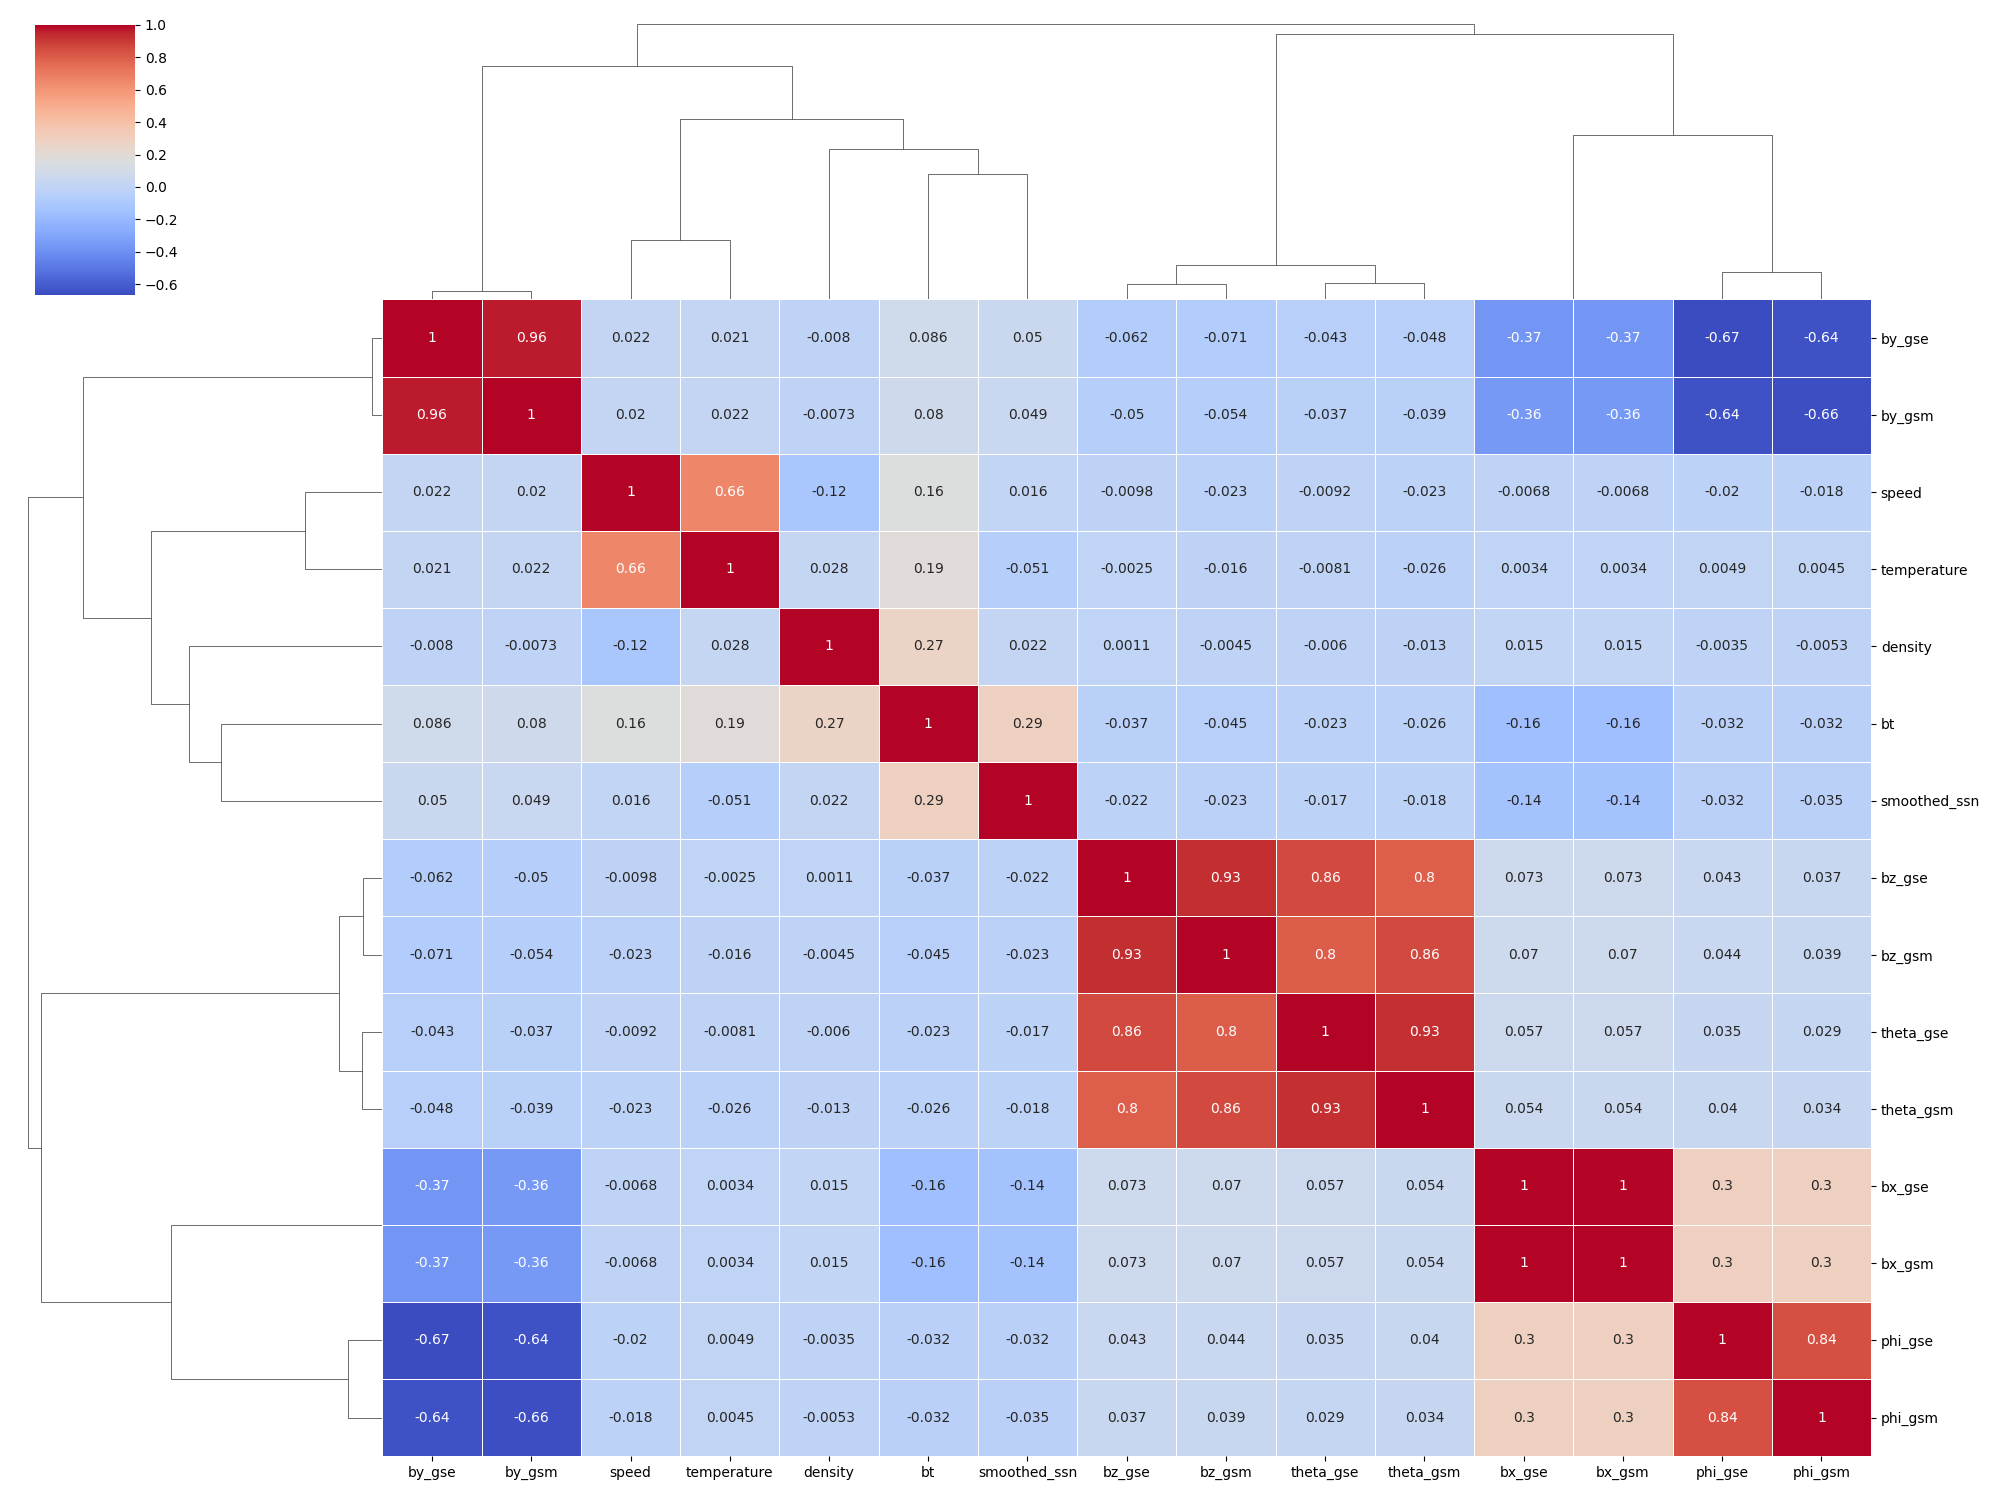

In [8]:
joined = solar_wind.join(sunspots).ffill()

numeric_cols = joined.select_dtypes(include=['number'])

corr = numeric_cols.corr()

plt.figure(figsize=(20, 15))
sns.clustermap(corr, annot=True, cmap="coolwarm", linewidths=.5, figsize=(20, 15))

plt.show()

In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
data = solar_wind.copy()
data.drop(columns=["source"], inplace=True)

scaler = StandardScaler()
scaler.fit(data)

normalized = pd.DataFrame(
    scaler.transform(data),
    index=data.index,
    columns=data.columns,
)

In [11]:
normalized.drop(columns=["bx_gsm",  "by_gsm",   "bz_gsm",   "theta_gsm",    "phi_gsm", "theta_gse", "phi_gse"], inplace=True)

In [12]:
normalized = normalized.groupby(["period", normalized.index.get_level_values(1).floor("H")]).agg(["mean", "std"])
normalized.columns = ["_".join(x) for x in normalized.columns]

<ipython-input-12-181da044bf60>:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  normalized = normalized.groupby(["period", normalized.index.get_level_values(1).floor("H")]).agg(["mean", "std"])


In [13]:
data = sunspots.copy()

scaler = StandardScaler()
scaler.fit(data)

sunspots_normalized = pd.DataFrame(
    scaler.transform(data),
    index=data.index,
    columns=data.columns,
)

In [14]:
normalized = normalized.join(sunspots).ffill()

In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam

In [16]:
def create_sequences(data, labels, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps)])
        y.append(labels[i + time_steps])
    return np.array(X), np.array(y)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(normalized, labels['dst'], test_size=0.2, random_state=42, shuffle=False)

In [18]:
time_steps = 128

X_train_seq, y_train_seq = create_sequences(X_train, y_train, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, time_steps)

X_train_seq = X_train_seq.reshape((X_train_seq.shape[0], X_train_seq.shape[1], X_train_seq.shape[2]))
X_test_seq = X_test_seq.reshape((X_test_seq.shape[0], X_test_seq.shape[1], X_test_seq.shape[2]))

<ipython-input-16-3da53a8cb235>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(labels[i + time_steps])


In [19]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(time_steps, X_train_seq.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(64, return_sequences=True))
model.add(Bidirectional(GRU(32)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(16))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.0001))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 126, 64)             │           2,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 63, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 63, 64)              │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 64)                  │          18,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 57,409 (224.25 KB)

 Trainable params: 57,409 (224.25 KB)

 Non-trainable params: 0 (0.00 B)

In [20]:
history = model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, validation_data=(X_test_seq, y_test_seq))

Epoch 1/10
3493/3493 ━━━━━━━━━━━━━━━━━━━━ 509s 142ms/step - loss: 322.4841 - val_loss: 57.6944
Epoch 2/10
3493/3493 ━━━━━━━━━━━━━━━━━━━━ 492s 141ms/step - loss: 166.2720 - val_loss: 63.6249
Epoch 3/10
3493/3493 ━━━━━━━━━━━━━━━━━━━━ 490s 137ms/step - loss: 150.1558 - val_loss: 56.6407
Epoch 4/10
3493/3493 ━━━━━━━━━━━━━━━━━━━━ 499s 137ms/step - loss: 139.2044 - val_loss: 56.8860
Epoch 5/10
3493/3493 ━━━━━━━━━━━━━━━━━━━━ 502s 136ms/step - loss: 127.3932 - val_loss: 58.9743
Epoch 6/10
3493/3493 ━━━━━━━━━━━━━━━━━━━━ 473s 136ms/step - loss: 121.2443 - val_loss: 56.0999
Epoch 7/10
3493/3493 ━━━━━━━━━━━━━━━━━━━━ 504s 136ms/step - loss: 119.4874 - val_loss: 54.3892
Epoch 8/10
3493/3493 ━━━━━━━━━━━━━━━━━━━━ 475s 136ms/step - loss: 114.9066 - val_loss: 58.0552
Epoch 9/10
3493/3493 ━━━━━━━━━━━━━━━━━━━━ 505s 137ms/step - loss: 111.4631 - val_loss: 59.7253
Epoch 10/10
3493/3493 ━━━━━━━━━━━━━━━━━━━━ 499s 136ms/step - loss: 108.5863 - val_loss: 56.6373


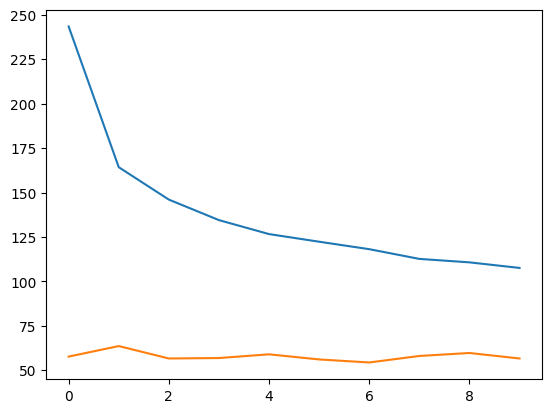

In [21]:
for name, values in history.history.items():

    plt.plot(values)

In [22]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [23]:
def evaluate_model(y_true, y_pred):
    r2 = r2_score(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    return r2, mse, mae

In [24]:
y_pred = model.predict(X_test_seq)

r2, mse, mae = evaluate_model(y_test_seq, y_pred)

print(f"R^2: {r2}")
print(f"MSE: {mse}")
print(f"MAE: {mae}")

871/871 ━━━━━━━━━━━━━━━━━━━━ 33s 36ms/step
R^2: 0.5338746309280396
MSE: 56.63734436063343
MAE: 5.581702578168701


In [25]:
mse = model.evaluate(X_test_seq,y_test_seq)
print(f"Test MSE: {mse:.2f}")
print(f"Test RMSE: {mse**.5:.2f}")

871/871 ━━━━━━━━━━━━━━━━━━━━ 31s 36ms/step - loss: 58.8409
Test MSE: 56.64
Test RMSE: 7.53


In [26]:
import pickle

# Salvar o modelo no arquivo .pkl
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)